In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import pandas as pd
df = pd.read_csv(
    "../data/processed/zerodha_kite_reviews_with_topics.csv",
    parse_dates=["review_date"]
)
topic_counts = (
    df.set_index("review_date")
      .groupby("dominant_topic", group_keys=False)
      .resample("ME")
      .size()
      .unstack("dominant_topic")
      .fillna(0)
)
topic_sentiment = pd.read_csv(
    "../data/processed/zerodha_kite_monthly_topic_sentiment.csv",
    index_col=0,
    parse_dates=True
)
topic_counts.head(), topic_sentiment.head()

C:\Users\swast\AppData\Local\Temp\ipykernel_23148\375090728.py:10: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


(dominant_topic    0   1   2    3   4   5
 review_date                             
 2025-08-31       42  33  25   35  19  16
 2025-09-30      199  72  66  152  87  49
 2025-10-31      221  84  60  122  79  56
 2025-11-30      137  72  74  146  57  48
 2025-12-31       78  37  44   91  44  26,
                     0         1         2         3         4         5
 review_date                                                            
 2025-08-31   0.259590  0.495812  0.457288  0.438131  0.398847  0.180325
 2025-09-30   0.090649  0.460099  0.492300  0.315364  0.304599  0.187031
 2025-10-31   0.080556  0.417376  0.483545  0.315591  0.319567  0.340141
 2025-11-30   0.243330  0.539857  0.462415  0.298140  0.356763  0.432821
 2025-12-31   0.084596  0.434341  0.423589  0.304459  0.213980  0.340023)

In [4]:
def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) < 2:
        return 0
    return np.polyfit(x, y, 1)[0]

In [5]:
def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) < 2:
        return 0
    return np.polyfit(x, y, 1)[0]

In [6]:
topic_velocity = topic_counts.apply(compute_slope)
topic_velocity

dominant_topic
0     1.0
1     0.8
2     4.6
3    10.6
4     2.0
5     1.9
dtype: float64

In [7]:
sentiment_trend = topic_sentiment.apply(compute_slope)
sentiment_trend

0   -0.019731
1   -0.004318
2   -0.009728
3   -0.028457
4   -0.031757
5    0.056519
dtype: float64

In [10]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())
velocity_norm = normalize(topic_velocity)
sentiment_norm = normalize(sentiment_trend)

In [11]:
ffi = velocity_norm * (1 - sentiment_norm)

In [12]:

topic_velocity.index = topic_velocity.index.astype(int)
sentiment_trend.index = sentiment_trend.index.astype(int)
velocity_norm.index = velocity_norm.index.astype(int)
sentiment_norm.index = sentiment_norm.index.astype(int)
ffi.index = ffi.index.astype(int)

In [13]:
ffi_df = pd.DataFrame({
    "topic_velocity": topic_velocity,
    "sentiment_trend": sentiment_trend,
    "velocity_norm": velocity_norm,
    "sentiment_norm": sentiment_norm,
    "feature_fatigue_index": ffi
}).sort_values("feature_fatigue_index", ascending=False)

ffi_df


,topic_velocity,sentiment_trend,velocity_norm,sentiment_norm,feature_fatigue_index
3,10.6,-0.028457,1.000000,0.037387,0.962613
2,4.6,-0.009728,0.387755,0.249545,0.290993
4,2.0,-0.031757,0.122449,0.000000,0.122449
0,1.0,-0.019731,0.020408,0.136237,0.017628
1,0.8,-0.004318,0.000000,0.310829,0.000000
5,1.9,0.056519,0.112245,1.000000,0.000000


In [14]:
topic_labels = {
    0: "General App Satisfaction",
    1: "Platform Reliability & Trust",
    2: "Core User Experience & Usability",
    3: "Feature Requests & Interface Overload",
    4: "Customer Support & Accessibility",
    5: "Minor UI Feedback & Responsiveness"
}

ffi_df["topic_label"] = ffi_df.index.map(topic_labels)
ffi_df


,topic_velocity,sentiment_trend,velocity_norm,sentiment_norm,feature_fatigue_index,topic_label
3,10.6,-0.028457,1.000000,0.037387,0.962613,Feature Requests & Interface Overload
2,4.6,-0.009728,0.387755,0.249545,0.290993,Core User Experience & Usability
4,2.0,-0.031757,0.122449,0.000000,0.122449,Customer Support & Accessibility
0,1.0,-0.019731,0.020408,0.136237,0.017628,General App Satisfaction
1,0.8,-0.004318,0.000000,0.310829,0.000000,Platform Reliability & Trust
5,1.9,0.056519,0.112245,1.000000,0.000000,Minor UI Feedback & Responsiveness


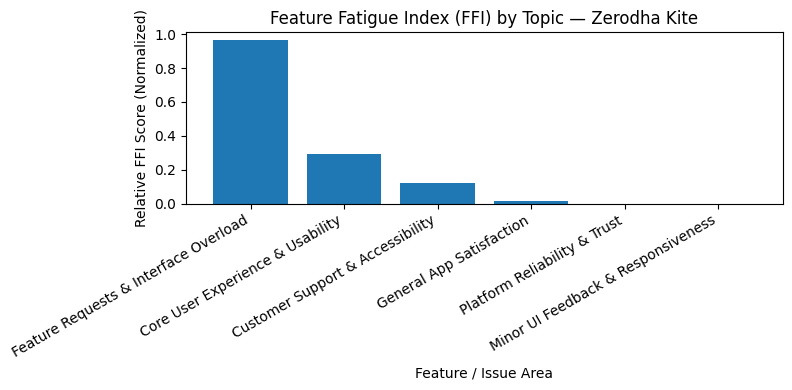

In [15]:
plt.figure(figsize=(8, 4))
plt.bar(
    ffi_df["topic_label"],
    ffi_df["feature_fatigue_index"]
)
plt.title("Feature Fatigue Index (FFI) by Topic — Zerodha Kite")
plt.xlabel("Feature / Issue Area")
plt.ylabel("Relative FFI Score (Normalized)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(
    "../visuals/feature_fatigue_index_by_topic.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [16]:
ffi_df.to_csv("../data/processed/zerodha_kite_feature_fatigue_index_.csv")

### Topic Validation (Exploratory – for Labeling Only)

The following cell was used during exploratory analysis to validate topic semantics
using representative user reviews. It is retained for transparency but is not part
of the final metric computation.

In [23]:
for t in sorted(df["dominant_topic"].unique()):
    print(f"\n=== Topic {t} — Sample Reviews ===")
    print(
        df[df["dominant_topic"] == t]["review_text"]
        .dropna()
        .sample(5, random_state=42)
        .to_string(index=False)
    )



=== Topic 0 — Sample Reviews ===
                                       very good 👍
    very nice app and always straight to the point
                                       Very good 👍
I’ve revised my rating — Zerodha truly stands o...
                  best app for share market tading

=== Topic 1 — Sample Reviews ===
                ZERODHA means is huge trust for me
                                 very good service
scheduled maintenance on the Kite platform. Exp...
I am happy with this app and customer support i...
           very reliable and good customer support

=== Topic 2 — Sample Reviews ===
Best navigation and user experience. Easy to tr...
                  user friendly and prompt support
very bad for heavy charge foolish people and no...
                     Good customer care executives
    Very quick & helpful response by Team Zerodha.

=== Topic 3 — Sample Reviews ===
please add an instant buy sell button in the mo...
Add features like 1. corporate action of holdin.